<a href="https://colab.research.google.com/github/AJ-Horch/customer_lifetime_value_prediction/blob/main/Customer_Lifetime_Value_Prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Lifetime Value Prediciton
Data: [Online Retail Data from UCI Repo](https://archive.ics.uci.edu/dataset/352/online+retail)

CLV is the total net revenue a company can expect from a single customer throughout their relationship
- The first objective is to calculate and predict future CLV, whic will help you find out how much each customer will spend
- The second objective is to identify profitable customers. The model will tell you who those valuable customers are
- The third goal is to take marketing actions based on the analysis from there, you will be able to optiize your marketing budget.


In [1]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 9.0 MB/s eta 0:00:00


In [2]:
!pip install openpyxl

In [3]:
!pip install arviz

In [4]:
# import required libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from arviz.labels import MapLabeller

from IPython.display import Image
from pymc_marketing import clv

In [5]:
# setting the style of the plots
az.style.use('arviz-darkgrid')

%config InlineBackend.figure_format = 'retina' # good looking plots


In [6]:
import requests
import zipfile
import os

# Download the zip file
url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"
reponse = requests.get(url)
filename = 'online_retial.zip'

with open(filename, 'wb') as file:
  file.write(reponse.content)

# unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('online_retail_data')

# finding the excel file name
for file in os.listdir('online_retail_data'):
  if file.endswith(".xlsx"):
    excel_file = os.path.join("online_retail_data", file)
    break

# convert from excel to csv
data_raw = pd.read_excel(excel_file)

data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
# If the InvoiceNo starts with 'c' it indicates a cancellation
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")]

# Create a temporary DF with the columns I want to match on. Also negate the 'Quantity col
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the orginal DF with the temp on the columns I want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity',
                                                   'UnitPrice']],
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'],
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the orginal return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])

<ipython-input-8-a3cc6ad36fa9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_orders['Quantity'] = -cancelled_orders['Quantity']


In [9]:
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Selecting relevant features and calculating total sales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs - they dont contribute to individual customer behaviour
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
print(data.shape)
data.head()

(392695, 7)


<ipython-input-10-0a3b624623c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


In [11]:
# Check for any missing values
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns=['Count', 'Proportion'], index=data.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
Country,0,0.0
TotalSales,0,0.0


In [12]:
# Summarize the dataset's content to understand its scope
maxdate = data['InvoiceDate'].dt.date.max()
mindate = data['InvoiceDate'].dt.date.min()
unique_cust = data['CustomerID'].nunique()
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()

print(f"The time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total quantity sold: {tot_quantity}")
print(f"Total sales for the period: {tot_sales}")

The time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4326
Total quantity sold: 4913316
Total sales for the period: 8391630.964


In [13]:
# Prep a summary from transaction data, transforming individua transaction data into data at the customer level

data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm

/usr/local/lib/python3.11/dist-packages/pymc_marketing/clv/utils.py:268: UserWarning: clv_summary was renamed to rfm_summary
  warnings.warn("clv_summary was renamed to rfm_summary", UserWarning, stacklevel=1)


,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12349,12349,0.0,0.0,18.0,0.000000
12350,12350,0.0,0.0,310.0,0.000000
12352,12352,5.0,260.0,296.0,221.756000
...,...,...,...,...,...
18280,18280,0.0,0.0,277.0,0.000000
18281,18281,0.0,0.0,180.0,0.000000
18282,18282,1.0,119.0,126.0,77.840000


In [14]:
data_summary_rfm = data_summary_rfm[data_summary_rfm['monetary_value'] > 0]

Percentage of customers who purchased only once: 31.68%


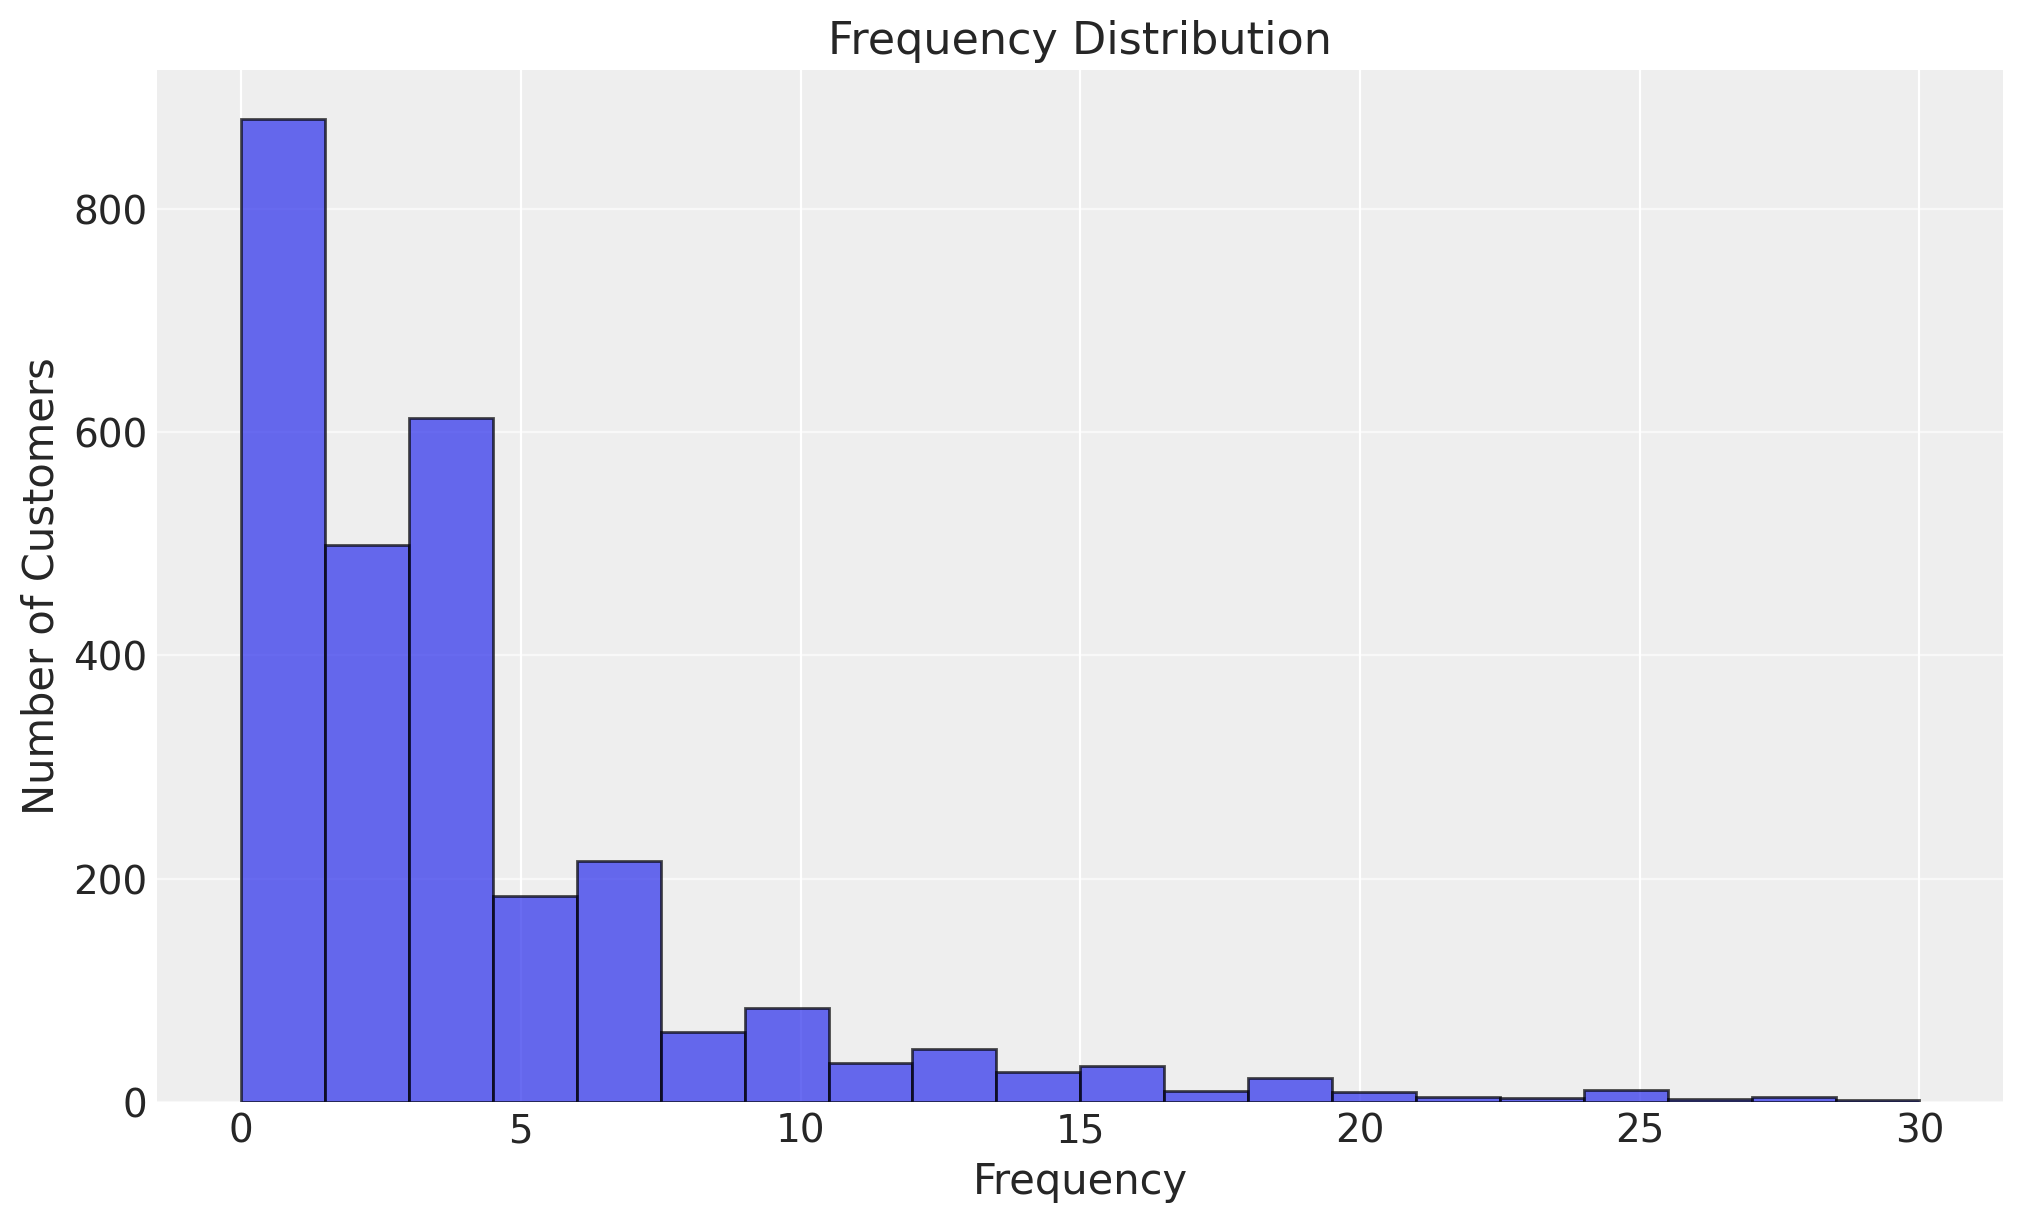

In [15]:
# Plotting the frequency dist of customers
plt.figure(figsize=(10, 6))
plt.hist(data_summary_rfm['frequency'], bins=20, range=[0, 30], edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show

one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")

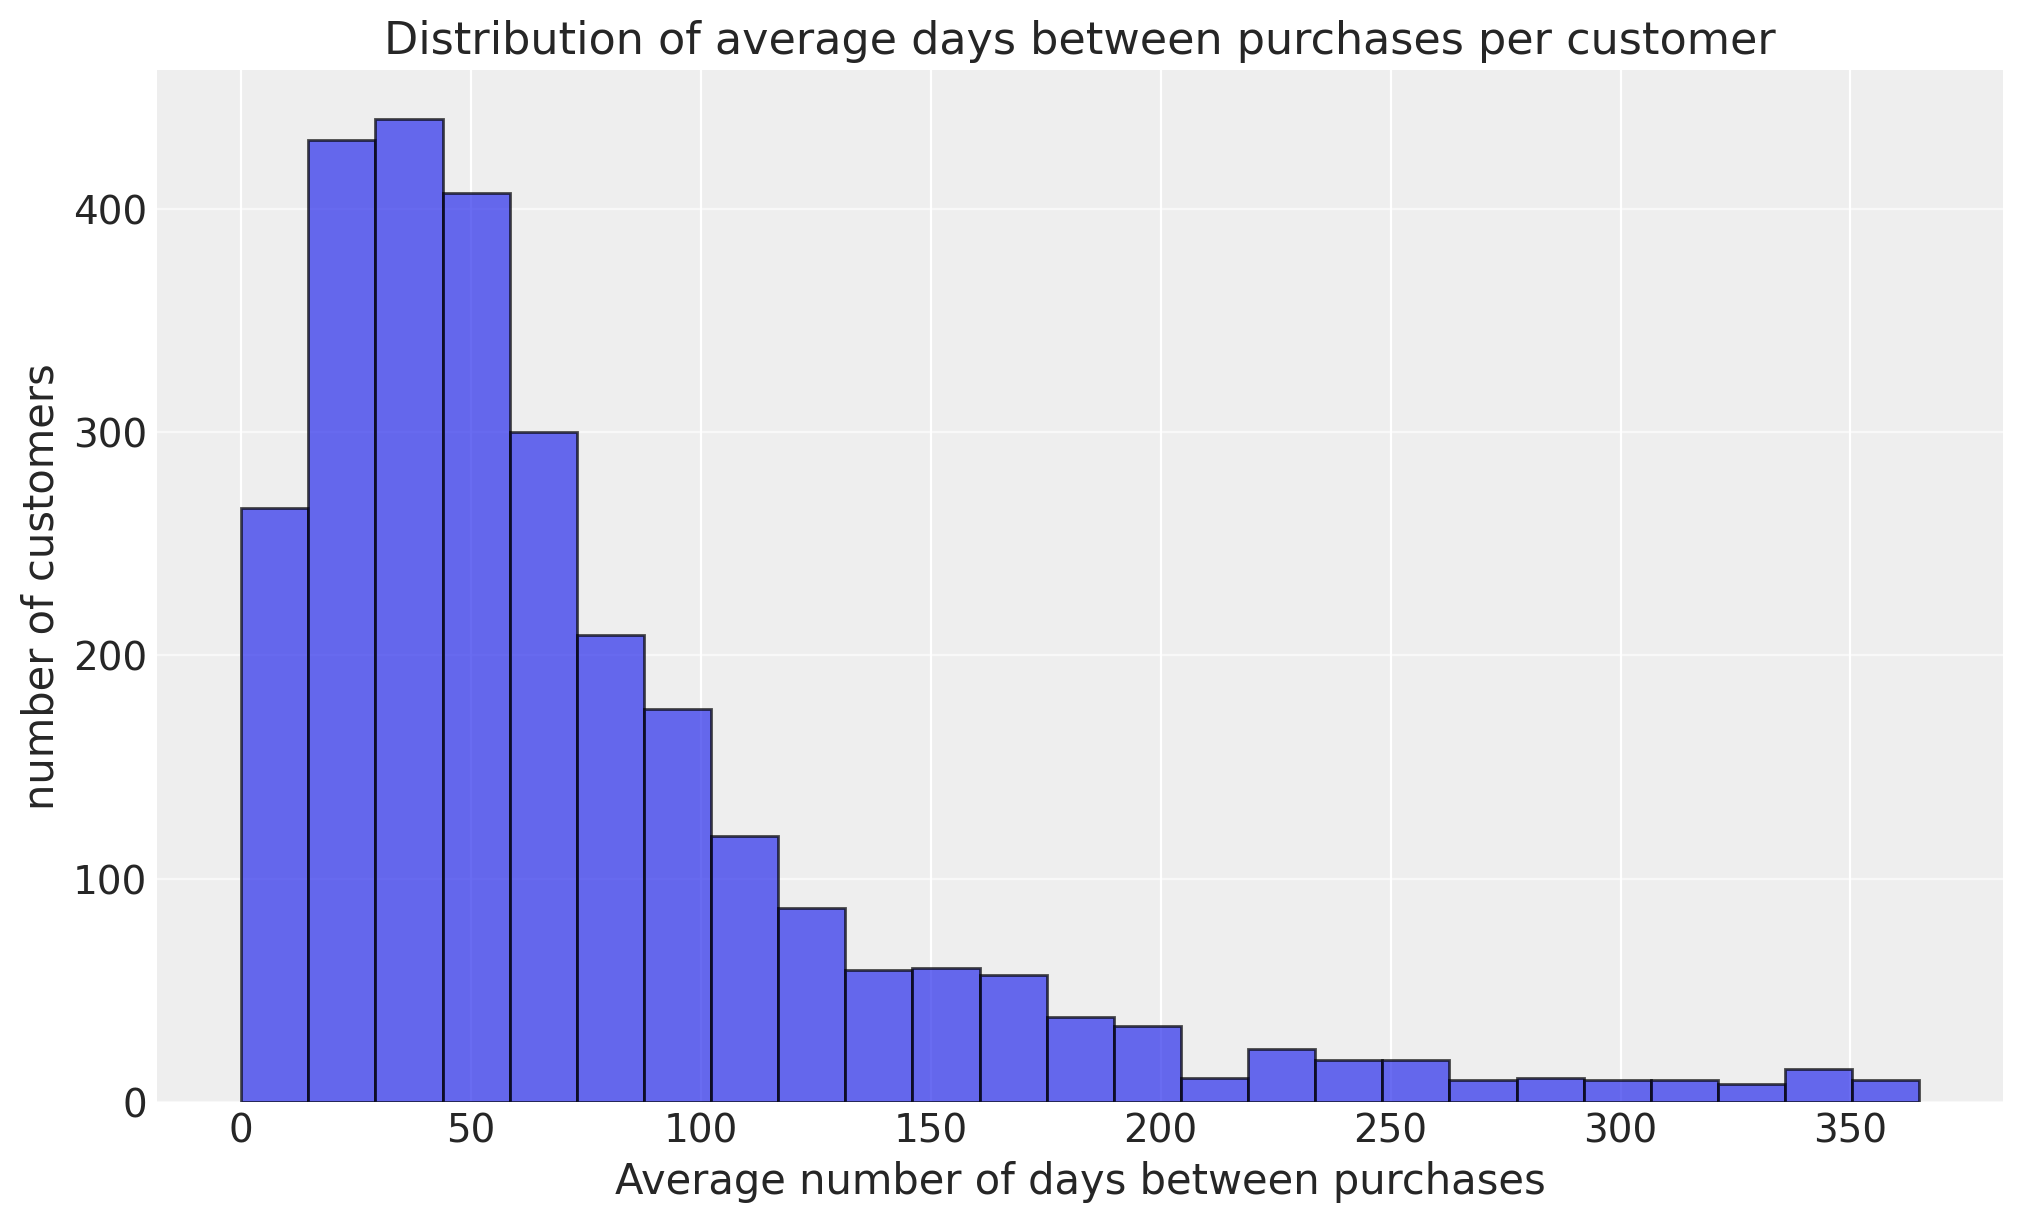

In [16]:
# Calculating Days between Purchases

# Select distinct CustomerID and InvoiceData
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
unique_purchases = data[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sorting values to esure the calculation of the difference correctly
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['InvoiceDate']).dt.days

# Calculate average days
customer_avg_days = unique_purchases.groupby('CustomerID')['DaysBetween'].mean().dropna()

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(customer_avg_days, bins=25, edgecolor='k', alpha=0.7)
plt.title('Distribution of average days between purchases per customer')
plt.xlabel('Average number of days between purchases')
plt.ylabel('number of customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [17]:
data_summary_rfm

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12352,12352,5.0,260.0,296.0,221.756000
12356,12356,2.0,303.0,325.0,269.905000
12358,12358,1.0,149.0,150.0,683.200000
...,...,...,...,...,...
18272,18272,5.0,244.0,246.0,487.752000
18273,18273,2.0,255.0,257.0,76.500000
18282,18282,1.0,119.0,126.0,77.840000


In [18]:
# Initializing the BG/NBD model
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()
bgm

BG/NBD
            alpha ~ Weibull(2, 10)
      phi_dropout ~ Uniform(0, 1)
    kappa_dropout ~ Pareto(1, 1)
                r ~ Weibull(2, 1)
                a ~ Deterministic(f(kappa_dropout, phi_dropout))
                b ~ Deterministic(f(kappa_dropout, phi_dropout))
recency_frequency ~ BetaGeoNBD(a, b, r, alpha, <constant>)

### Configuring the model
While the default priors work well for large datasets, they can be too broad for smaller datasets. Therefore, we're refining our model by specifying more informative priors for the model's paramters. This step helps guiding the model towards more realistic areas of the parameter space

In [21]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},

}

In [24]:
# rebuild the model with the new config
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
            alpha ~ HalfNormal(0, 100)
                a ~ HalfNormal(0, 100)
                b ~ HalfNormal(0, 100)
                r ~ HalfNormal(0, 100)
recency_frequency ~ BetaGeoNBD(a, b, r, alpha, <constant>)